In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit

## Set Hyperparameters


In [34]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA

BATCH_SIZE = 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42,128,128,3)
NUM_CLASSES = 40

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 650

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 4
NUM_LAYERS = 3

## Load DATA

In [36]:
# Load the processed videos and labels from the saved files
save_path = '/content/drive/MyDrive/vivit/ProcessedData/all'

videos = np.load(os.path.join(save_path, 'videos.npy'))
labels = np.load(os.path.join(save_path, 'labels.npy'))

In [43]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.1, random_state=2334)

# Optionally, you can further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567,)
# Print the shapes of the training and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (972, 42, 128, 128, 3)
y_train shape: (972,)
X_test shape: (120, 42, 128, 128, 3)
y_test shape: (120,)


## Set up Vivit Model

In [45]:
#Define the TubeletEmbedding and PositionalEncoder layers
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

# Create the ViViT model
def create_vivit_classifier():
    # Get the input layer
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Create patches.
    tubelet_embedder = TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE)
    patches = tubelet_embedder(inputs)
    # Encode patches.
    positional_encoder = PositionalEncoder(embed_dim=PROJECTION_DIM)
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(NUM_LAYERS):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM // NUM_HEADS, dropout=0.2
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=PROJECTION_DIM * 4, activation=tf.nn.gelu),
                layers.Dense(units=PROJECTION_DIM, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define custom metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Create and compile the ViViT model
model = create_vivit_classifier()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        recall_m,
        precision_m,
        f1_m,
    ],
)

# Prepare data loaders using tf.data
def prepare_dataloader(video_data, label_data, split_name):
    dataset = tf.data.Dataset.from_tensor_slices((video_data, label_data))
    if split_name == "train":
        dataset = dataset.shuffle(buffer_size=len(video_data))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

trainloader = prepare_dataloader(X_train, y_train, "train")
validloader = prepare_dataloader(X_val, y_val, "valid")
testloader = prepare_dataloader(X_test, y_test, "test")


# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor (usually validation loss)
    patience=20,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/vivit/lmao',  # Include the epoch number in the filename
    monitor='val_loss',
    save_best_only=True,  # Save weights after each epoch
    save_weights_only=False,  # Save only the weights, not the entire model
    verbose=2
)


## Training Process

In [ ]:
# Train the model
history = model.fit(
    trainloader,
    epochs=EPOCHS,
    validation_data=validloader,
    callbacks=[model_checkpoint],
    verbose=2
)

In [16]:
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/vivit/lmao',
    custom_objects={'recall_m': recall_m, 'precision_m': precision_m, 'f1_m': f1_m}
)

In [17]:
testloader

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 42, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
test_loss, test_accuracy, test_recall, test_precision, test_f1 = model.evaluate(testloader)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)

50/50 [==============================] - 1s 11ms/step - loss: 0.4049 - accuracy: 0.8900 - recall_m: 1.5600 - precision_m: 1.7900 - f1_m: 1.6300
Test Loss: 0.404893696308136
Test Accuracy: 0.8899999856948853
Test Recall: 1.559999942779541
Test Precision: 1.7899999618530273
Test F1 Score: 1.6299999952316284


50/50 [==============================] - 1s 17ms/step


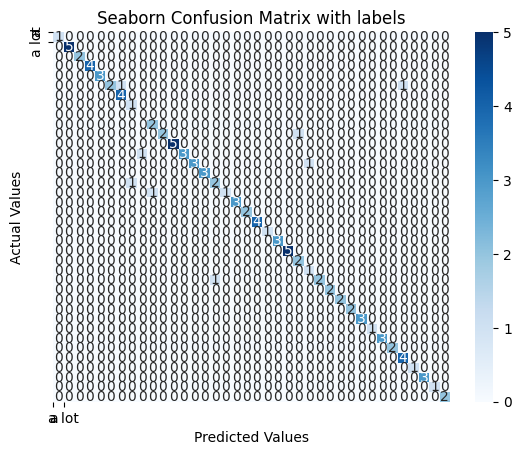

In [ ]:
# Use the model to predict on your test data
y_preds = np.argmax(model.predict(testloader), axis=1)

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

# Create a heatmap
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Define the tick labels and locations
tick_labels = ['a', 'a lot']  # Replace with your class labels
tick_locations = np.arange(len(tick_labels))

# Set the tick labels and locations for both axes
ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_locations)
ax.set_yticklabels(tick_labels)

# Display the visualization of the Confusion Matrix
plt.show()


In [ ]:
NUM_SAMPLES_VIZ = 200

testsamples, labels_ = next(iter(testloader))
testsamples, labels_ = X_test[:NUM_SAMPLES_VIZ], y_test[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos_ = []

for i, (testsample, label) in enumerate(zip(testsamples, labels_)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample * 255).astype("uint8"), "GIF", duration=5)
        videos_.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb



boxes = []
label_dict = {
    0: 'sheep',
    1: 'red',
    2: 'month',
    3: 'hamburger',
    4: 'night',
    5: 'pizza',
    6: 'pear',
    7: 'orange',
    8: 'horse',
    9: 'pig',
    10: 'milk',
    11: 'green',
    12: 'lemon',
    13: 'mom',
    14: 'summer',
    15: 'white',
    16: 'uncle',
    17: 'winter',
    18: 'worker',
    19: 'week',
    20: 'spring',
    21: 'will-(future)',
    22: 'apple',
    23: 'architect',
    24: 'artist',
    25: 'autumn',
    26: 'banana',
    27: 'bird',
    28: 'black',
    29: 'blue',
    30: 'brown',
    31: 'candy',
    32: 'cat',
    33: 'cow',
    34: 'dad',
    35: 'day',
    36: 'director',
    37: 'dog',
    38: 'gold & silver',
    39: 'grapes'
}
for i in range(min(NUM_SAMPLES_VIZ, len(videos_))):
    ib = ipywidgets.widgets.Image(value=videos_[i], width=128, height=128)
    true_class = label_dict[ground_truths[i]]
    pred_class = label_dict[preds[i]]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

1/1 [==============================] - 0s 31ms/step


GridBox(children=(VBox(children=(HTML(value="'T: winter | P: winter'"), Box(children=(Image(value=b'GIF89a\x80…

In [48]:
words_list = [
    'sheep',
    'red',
    'month',
    'hamburger',
    'night',
    'pizza',
    'pear',
    'orange',
    'horse',
    'pig',
    'milk',
    'green',
    'lemon',
    'mom',
    'summer',
    'white',
    'uncle',
    'winter',
    'worker',
    'week',
    'spring',
    'will-(future)',
    'apple',
    'architect',
    'artist',
    'autumn',
    'banana',
    'bird',
    'black',
    'blue',
    'brown',
    'candy',
    'cat',
    'cow',
    'dad',
    'day',
    'director',
    'dog',
    'gold & silver',
    'grapes'
]


In [49]:
for x in words_list:
  print(x)

sheep
red
month
hamburger
night
pizza
pear
orange
horse
pig
milk
green
lemon
mom
summer
white
uncle
winter
worker
week
spring
will-(future)
apple
architect
artist
autumn
banana
bird
black
blue
brown
candy
cat
cow
dad
day
director
dog
gold & silver
grapes


In [22]:
pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 52.6 MB/s eta 0:00:00


In [25]:
pip install opencv-python-headless

In [31]:
import os
import cv2
import numpy as np
import mediapipe as mp
max_videos_per_class = 30  # Maximum videos to process per class
min_frames_required = 30  # Minimum frames required in each video
videos_to_skip = 3  #
mp_holistic = mp.solutions.holistic.Holistic(static_image_mode=False, min_detection_confidence=0.2, min_tracking_confidence=0.2)
mp_hands = mp.solutions.hands.Hands(static_image_mode=False, min_detection_confidence=0.2, min_tracking_confidence=0.2)

def apply_mediapipe_holistic(frame):
    # Create a black background
    global mp_holistic
    black_frame = frame.copy()
    black_frame[:] = (0, 0, 0)

    # Convert the frame to RGB (Mediapipe requires RGB input)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with Mediapipe Holistic
    results = mp_holistic.process(frame_rgb)

    # Draw the pose landmarks with orange color
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            black_frame, results.pose_landmarks, mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(255, 165, 0), thickness=1, circle_radius=1),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(255, 165, 0), thickness=1))

    # Draw the left hand landmarks with blue color
    if results.left_hand_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            black_frame, results.left_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=1, circle_radius=1),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=1))

    # Draw the right hand landmarks with purple color
    if results.right_hand_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            black_frame, results.right_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(128, 0, 128), thickness=1, circle_radius=1),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(128, 0, 128), thickness=1))

    return black_frame

cap = cv2.VideoCapture(0)
while True:
  ret, frame = cap.read()
  cv2.imshow('frame',frame)
  if not ret:
    break

  processed_frame = apply_mediapipe_holistic(frame)

    # Display the processed frame
  cv2.imshow('Processed Frame', processed_frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
      break




DisabledFunctionError: ignored

In [ ]:
# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()